In [1]:
import sympy as sm
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.signal as sig
from systemprbm import UnitCell, System
%matplotlib inline

#Define degrees of freedom, and initial values




In [2]:
# Define mechanism parameters
E = 2.2e9 #Young's modulus
t = 0.4e-3 #thickness
b = 5e-3    #width
Lf1 = 6e-3 #length of the flexure on end effector, and bifurcation
Lf2 = 4e-3 #length of the flexure on signal routing and bistable beams
Lr1 = 35e-3 #length of the rigid link on end effector
Lr2 = 24e-3 #length of the rigid link on bistable beams
Lr3 = 35e-3 #length of the rigid link on signal routing
Lr4 = 60e-3 #length of the rigid link on bifurcation
Ls1 = 6e-3 #length of the support on bistable beams
ts1 = 2e-3 #thickness of the support on bistable beams
Lsignal = 6e-3 #length of the signal routing spring leg

alpha0 = 24*np.pi/180 #initial angle of the end effector
beta0 = 8*np.pi/180 #initial angle of the bistable beams
gamma0 = 30*np.pi/180 #initial angle of the signal routing
theta0 = 1*np.pi/180 #initial angle of the bifurcation

kf1 = E*b*t**3/12/Lf1
kf2 = E*b*t**3/12/Lf2
kf3 = E*b*t**3/12/Lf2
kf4 = E*b*t**3/12/Lf1

C1 = E*b*ts1**3/Ls1**3 #bistable support stiffness
C2 = 2*E*b*t**3/Lr2**3 #signal routing guiding stiffness
C3 = 0.2*E*b*t**3/Lsignal**3/6 #signal routing stiffness
C4 = 500000 #bifurcation support stiffness

#todo fix these values

K1 = 0
K2 = 0
K3 = 0

tog_offset = 3e-3

params = {
    'L1': Lr1+Lf1,'L2': Lr2+Lf2,'L3': Lr3+Lf2,'L4': Lr4+Lf1,
    'C1': C1,'C2': C2,'C3': C3,'C4': C4,
    'Kf1': kf1,'Kf2': kf2,'Kf3': kf3,'Kf4': kf4,
    'alpha0': alpha0,'beta0': beta0,'gamma0': gamma0,'theta0': theta0,
    'K1': K1,'K2': K2,'K3': K3,
    'tog_offset': tog_offset,
    } 




In [3]:
config = [0]



In [4]:
#plot the force residuals as a function of d0
def plot_force_residuals(force_residuals):
    alpha_range = np.linspace(alpha0,-alpha0,100)
    d0 = params['L1']*(np.sin(params['alpha0'])-np.sin(alpha_range))
    plt.figure()
    plt.plot(d0,-force_residuals[:,0])

    #find the zero crossings, and interpolate to find the exact zero crossing
    zero_crossings = np.where(np.diff(np.sign(force_residuals[:,0])))[0][-1]
    peaks, _ = sig.find_peaks(-force_residuals[:,0],height=0.1)
    
    #interpolate to find the exact zero crossing
    d0_at_zero_crossings = d0[zero_crossings] - (d0[zero_crossings+1]-d0[zero_crossings])*(force_residuals[zero_crossings,0])/(force_residuals[zero_crossings+1,0]-force_residuals[zero_crossings,0])
    print('d0 at zero crossings: {:.2f}'.format(d0_at_zero_crossings*1000))
    
    
    #draw lines from the last zero crossing to the peaks of the force residuals, y value at zero crossing is 0
    slopes = np.zeros(len(peaks))
    for i,peak in enumerate(peaks):
        plt.plot([d0_at_zero_crossings,d0[peak]],[0,-force_residuals[peak,0]],'r')
        
        slope = (-force_residuals[peak,0])/(d0[peak]-d0_at_zero_crossings)
        slopes[i] = slope

    #print the ratio of the slopes on the figure
    plt.text(0.01,0.01,'slopes ratio: {:.2f}'.format(slopes[1]/slopes[0]),transform=plt.gca().transAxes)
    #print the slopes on the figure at the midpoint of the lines
    plt.text(0.01,0.05,'slopes: {:.2f}, {:.2f}'.format(-slopes[0],-slopes[1]),transform=plt.gca().transAxes)

    print('slopes ratio: {:.2f}'.format(slopes[1]/slopes[0]))
    print('slopes: {:.2f}, {:.2f}'.format(slopes[0],slopes[1]))



    plt.xlabel('d0 (m)')
    plt.ylabel('Force (N)')
    plt.title('Force Residuals')

    plt.grid()


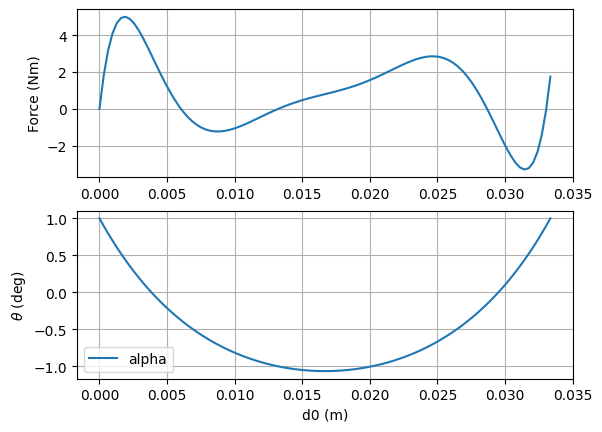

In [5]:
#creeat a system with one unit cell and get the force residuals as alpha is swept from 22 degrees to -22 degrees using the bounds, solving for the equilivrium state at each step, and plotting the force residuals

params['K1'] = 0
params['K2'] = 0
params['K3'] = 0
config = [0]
system = System(config,params)

alpha_range = np.linspace(alpha0,-alpha0,100)
force_residuals = np.zeros((len(alpha_range),2))
state_vectors = np.zeros((len(alpha_range),2))
energies = np.zeros(len(alpha_range))

bub = np.copy(system.bounds.ub)
blb = np.copy(system.bounds.lb)

for i,alpha in enumerate(alpha_range):
    #update the bounds
    blb[0] = alpha
    bub[0] = alpha

    system.bounds.ub = bub
    system.bounds.lb = blb
    #solve for the equilivrium state
    system.solve_equilibrium()

    #get the force residuals
    force_residuals[i] = system.compute_force_residuals()
    state_vectors[i] = system.state_vector
    energies[i] = system.compute_energy()
    




#find the peaks of the force residuals
peaks, _ = sig.find_peaks(-force_residuals[:,0],height=0.1)
zero_crossings = np.where(np.diff(np.sign(force_residuals[:,0])))[0]

plt.figure()
#create two subplots, one for the force residuals and one for the state vectors
#plot the negative of the force residuals against d0 as a function of alpha 

d0 = params['L1']*(np.sin(params['alpha0'])-np.sin(alpha_range))
ax1 = plt.subplot(211)
ax1.plot(d0,-force_residuals[:,0])


ax1.set_ylabel('Force (Nm)')
ax1.grid()

ax2 = plt.subplot(212)
#plot theta as a function of d0 
ax2.plot(d0,state_vectors[:,1]*180/np.pi)
ax2.set_xlabel('d0 (m)')
#set ylabels with actual theta symbol
ax2.set_ylabel(r'$\theta$ (deg)')
ax2.legend(['alpha','theta'])
ax2.grid()



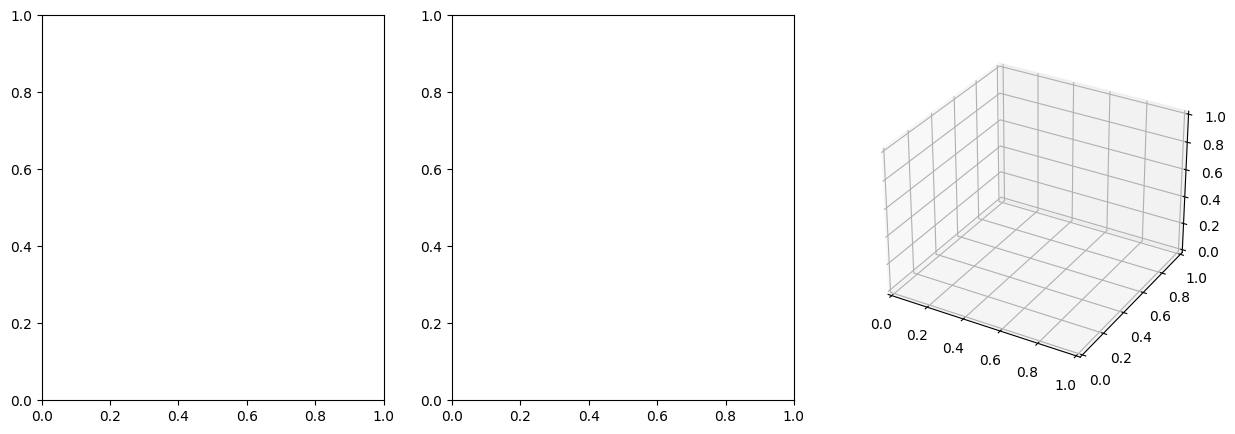

In [6]:
#create subplot with 1 row and 3 columns, figure size 15x5
fig, ax = plt.subplots(1, 3, figsize=(15,5))
#make 3rd subplot 3d
ax[2] = plt.subplot(1, 3, 3, projection='3d')

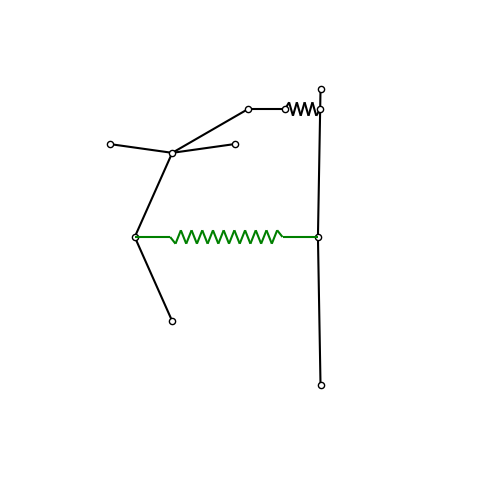

In [7]:

system.update_state([alpha0,theta0])
fig,ax = system.plot_system()

In [8]:
params['K1'] = 0
params['K2'] = 0   
params['K3'] = 0
config = [0]
system = System(config,params)
d6max = 33e-3
thetamax = np.arcsin(d6max/params['L4'])
system.set_bounds(system.alphalb,system.alphaub,thetamax,thetamax)

bub = np.copy(system.bounds.ub)
blb = np.copy(system.bounds.lb)



for i,alpha in enumerate(alpha_range):
    #update the bounds
    blb[0] = alpha
    bub[0] = alpha

    system.bounds.ub = bub
    system.bounds.lb = blb
    #solve for the equilivrium state
    system.solve_equilibrium()

    #get the force residuals
    force_residuals[i] = system.compute_force_residuals()
    state_vectors[i] = system.state_vector



d0 at zero crossings: 33.09
slopes ratio: 1.92
slopes: -166.50, -320.51


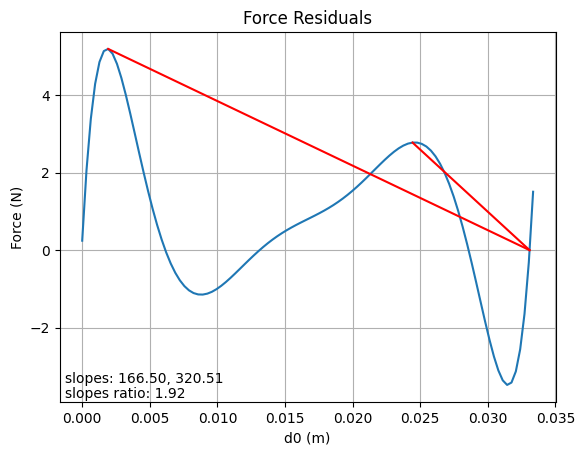

In [9]:
plot_force_residuals(force_residuals)

In [28]:

#rule 110
params['K1'] = 140
params['K2'] = 175
params['K3'] = 175

#rule 90
# params['K1'] = 200
# params['K2'] = 0
# params['K3'] = 200


params['tog_offset'] = 2e-3


# define initial configuration
config = [0,0,0,0,0,1]


# Create system
system = System(config,params)

d6max = 33e-3#+params['tog_offset']
umax = 2*(params['L4']-np.sqrt(params['L4']**2-d6max**2))

n_cycles = 6
input_offset = 0.1e-3
frames_per_cycle = 1000
t = np.linspace(0, n_cycles, int(frames_per_cycle*n_cycles))
u_range = (sig.sawtooth(2*np.pi*t, width=0.5)+1)/2*(umax+input_offset)-input_offset

results, y = system.simulate_actuation(u_range)



C:\Users\eoinl\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [29]:
results.shape

(6000, 12)

In [30]:
config

[0, 0, 0, 0, 0, 1]

Text(0, 0.5, 'u [m]')

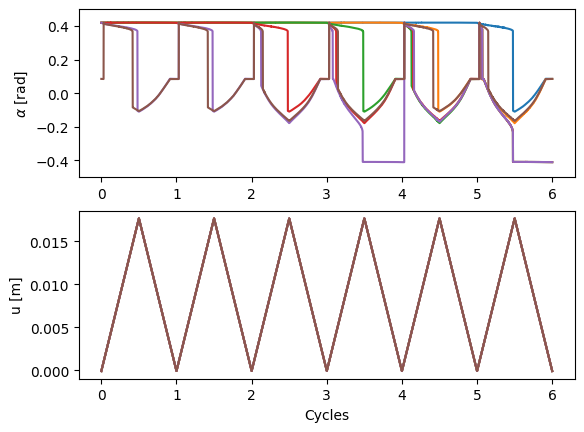

In [31]:


plt.figure()
plt.subplot(2, 1, 1)
for i in range(system.n):
    plt.plot(t, results[:, 2*i])

#axis labels
#label y axis with alpha symbol
plt.ylabel(r'$\alpha$ [rad]')
plt.ylim([-0.5, 0.5])


plt.subplot(2, 1, 2)
for i in range(system.n):
    plt.plot(t, u_range)

#axis labels
plt.xlabel('Cycles')
plt.ylabel('u [m]')
#label y axis with alpha symbol






In [44]:
from matplotlib.animation import FuncAnimation


In [46]:
%run systemprbm.py

<Figure size 640x480 with 0 Axes>

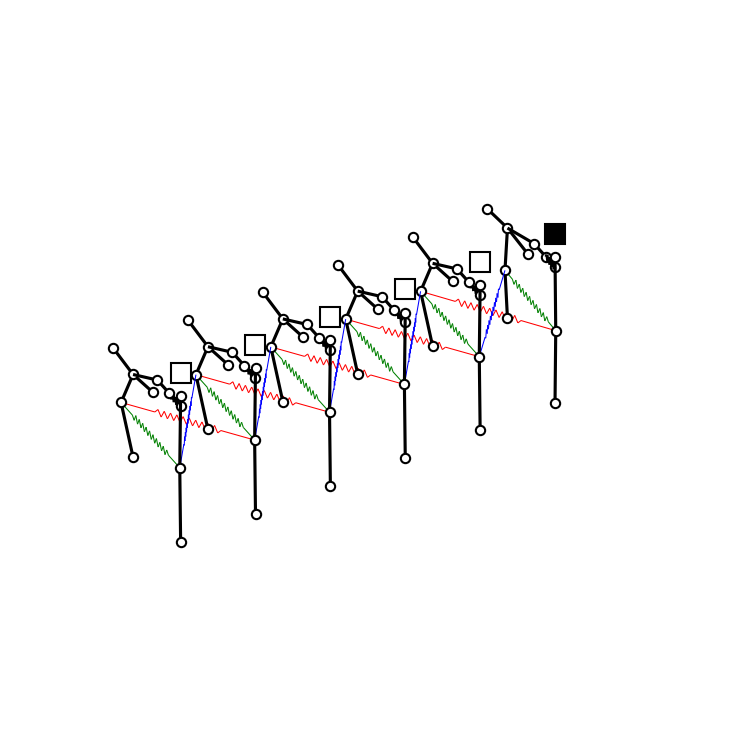

In [47]:
# Create system
system = System(config,params)
system.cell_spacing = 60e-3
system.solve_equilibrium()
fig, ax = system.plot_system()
ax.view_init(40, -30)
fig.dpi = 150
for i in range(len(config)):

    system.self_spring_lines[i].set_linewidth(0.5)
    if system.left_spring_lines[i] is not None:
        system.left_spring_lines[i].set_linewidth(0.5)
    if system.right_spring_lines[i] is not None:
        system.right_spring_lines[i].set_linewidth(0.5)


In [48]:
ani = FuncAnimation(fig,system.update_plot,fargs=(results,),frames=results.shape[0],interval=50,blit=True,repeat=False)

RuntimeError: The animation function must return a sequence of Artist objects.

In [12]:

theta_range = np.linspace(0,-0.6,100)
alpha_range = np.linspace(1.1*alpha0,-1.1*alpha0,100)



params['K1'] = 0
params['K2'] = 200
params['K3'] = 200
config = [0,1,0]
#central cell id 



energy_field = np.zeros((len(alpha_range),len(theta_range),len(config)))




for k in range(len(config)):
    system = System(config,params)
    bub = np.copy(system.bounds.ub)
    blb = np.copy(system.bounds.lb)
    for j,u in enumerate(theta_range):
        for i,alpha in enumerate(alpha_range):
        
            system.state_vector[2*k] = alpha
            system.state_vector[1] = -u
            system.state_vector[3] = u #central cell only
            system.state_vector[5] = -u #central cell only
            
            system.update_state(system.state_vector)
            #calculate the energy
            energy_field[i,j,k] = system.compute_energy()

    system.set_bounds(system.alphalb,system.alphaub,system.thetalb,system.thetaub)

    



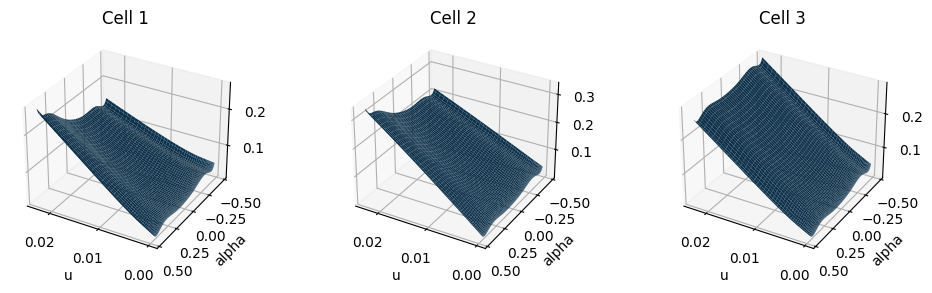

In [13]:
from mpl_toolkits.mplot3d import Axes3D  
fig= plt.figure(figsize=(12, 3))
#create meshgrid 
X,Y = np.meshgrid(2*(params['L4']*(1-np.cos(theta_range))),alpha_range)


#plot 3d surface
for cell in range(system.n):
    ax = fig.add_subplot(1,system.n,cell+1, projection='3d')
    ax.plot_surface(X,Y,energy_field[:,:,cell])
    ax.set_xlabel('u')
    ax.set_ylabel('alpha')
    ax.set_title('Cell '+str(cell+1))
    ax.view_init(30,120)






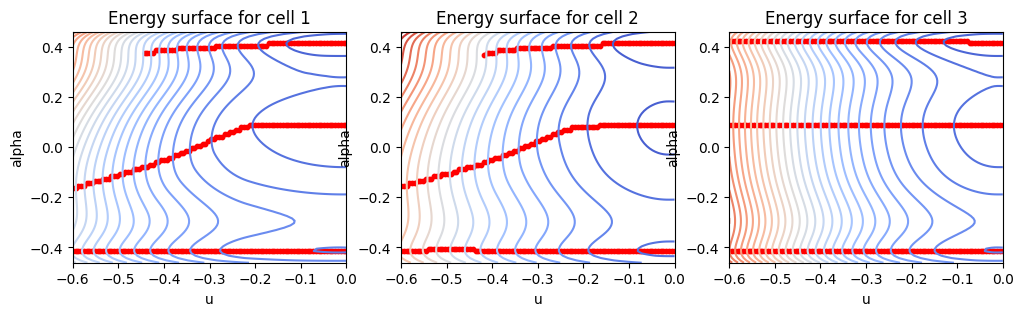

In [14]:
from mpl_toolkits.mplot3d import Axes3D  
import scipy.signal as sig
fig= plt.figure(figsize=(12, 3))
#create meshgrid 
X,Y = np.meshgrid(theta_range,alpha_range)


#plot 3d surface
for cell in range(system.n):
    ax = fig.add_subplot(1,system.n,cell+1)
    ax.contour(X,Y,energy_field[:,:,cell],cmap='coolwarm',levels=30
                ,vmin=energy_field.min(),vmax=energy_field.max())

    find_troughs = sig.argrelextrema(energy_field[:,:,cell], np.less,mode='wrap')
    ax.scatter(X[find_troughs],Y[find_troughs],c='r',s=10)
    ax.set_xlabel('u')
    ax.set_ylabel('alpha')
    ax.set_title('Energy surface for cell '+str(cell+1))



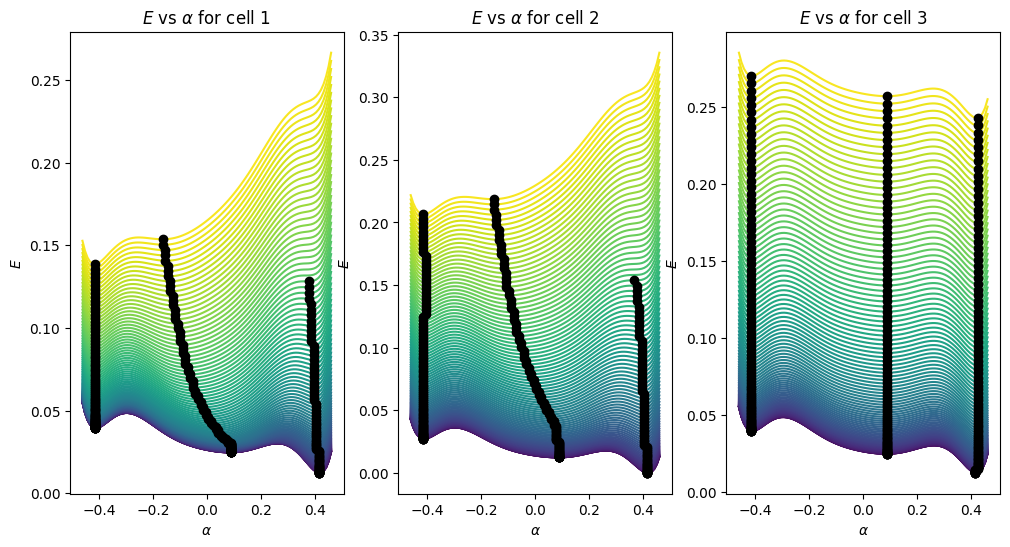

In [15]:

fig= plt.figure(figsize=(12, 6))
for cell in range(system.n):
    ax = fig.add_subplot(1, system.n, cell+1)
    
    for i in range(len(theta_range)):
        troughs = sig.find_peaks(-energy_field[:,i,cell],)
        ax.plot(alpha_range,energy_field[:,i,cell], label=r'$\theta$ = %.2f' %theta_range[i])
        #make the color of the line be a function of theta
        ax.lines[i].set_color(plt.cm.viridis(i/len(theta_range)))

        #find and plot troughs
        ax.scatter(alpha_range[troughs[0]],energy_field[:,i,cell][troughs[0]],zorder=10, color='black')
        
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$E$')
    ax.set_title(r'$E$ vs $\alpha$ for cell %d' %(cell+1))


In [16]:
%run systemprbm.py

<Figure size 640x480 with 0 Axes>

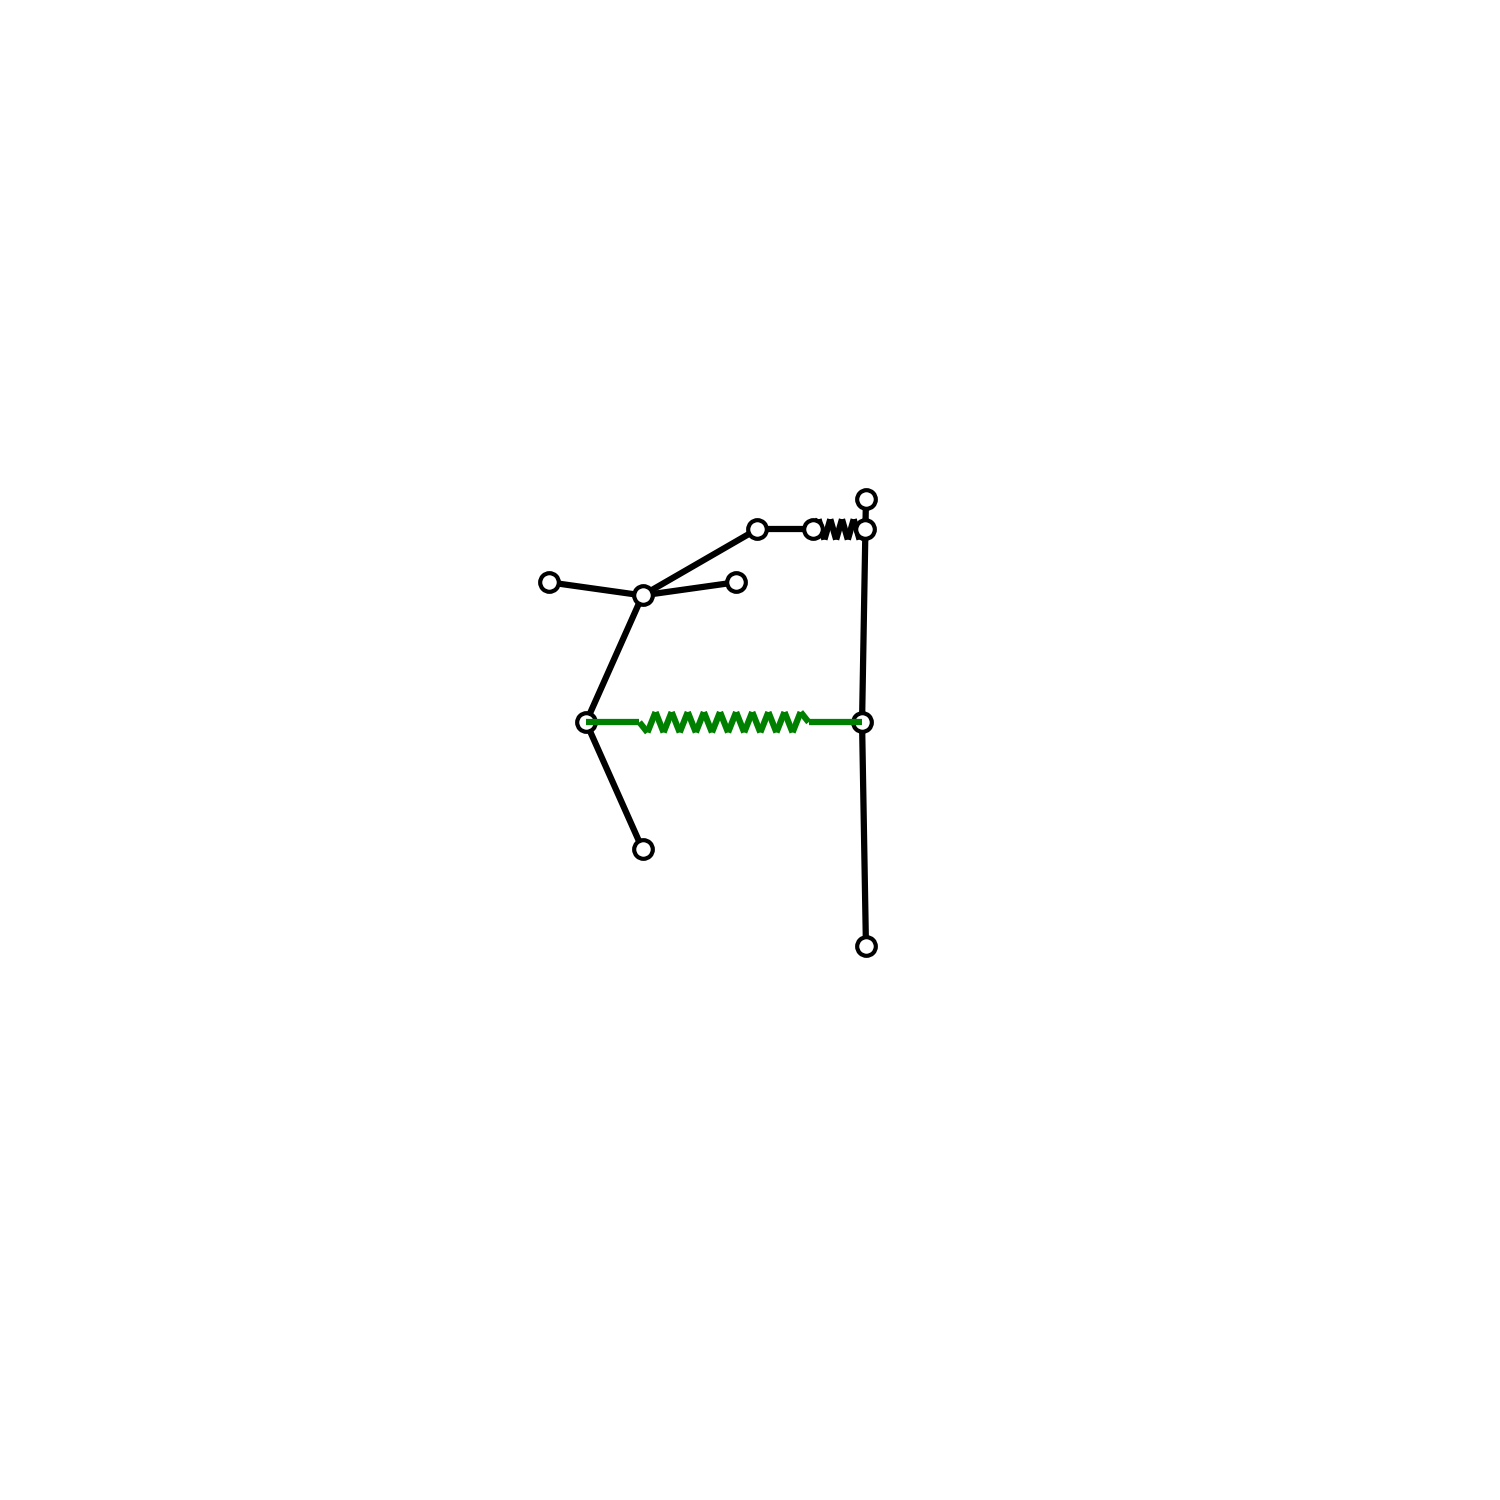

In [17]:

# params['K1'] = 0
# params['K2'] = 150
# params['K3'] = 0


# define initial configuration
# config = [0]*6


# Create system
system = System(config,params)
system.cell_spacing = 40e-3
system.solve_equilibrium()
fig, ax = system.plot_system()
ax.view_init(0, -90)
fig.dpi = 300

for i in range(len(config)):
    if i:
        system.tristable_lines[i].set_visible(False)
        system.tristable_joints[i].set_visible(False)
        system.tristable_lines[i].set_visible(False)
        system.tristable_joints[i].set_visible(False)
        system.signal_router_lines[i].set_visible(False)
        system.signal_router_joints[i].set_visible(False)
        system.bifurcation_lines[i].set_visible(False)
        system.bifurcation_joints[i].set_visible(False)
        system.signal_spring_lines[i].set_visible(False)
        system.self_spring_lines[i].set_visible(False)
    if system.left_spring_lines[i] is not None:
        system.left_spring_lines[i].set_visible(False)
    if system.right_spring_lines[i] is not None:
        system.right_spring_lines[i].set_visible(False)

        

In [18]:
def update(i):
    t1 = 60
    t2 = t1+10*len(system.tristable_lines)
    if i<t1:
        ax.view_init(elev=0.5*i, azim=-90+0.5*i)
    elif i<t2:
        system.tristable_lines[(i-t1)//10].set_visible(True)
        system.tristable_joints[(i-t1)//10].set_visible(True)
        system.tristable_lines[(i-t1)//10].set_visible(True)
        system.tristable_joints[(i-t1)//10].set_visible(True)
        system.signal_router_lines[(i-t1)//10].set_visible(True)
        system.signal_router_joints[(i-t1)//10].set_visible(True)
        system.bifurcation_lines[(i-t1)//10].set_visible(True)
        system.bifurcation_joints[(i-t1)//10].set_visible(True)
        system.signal_spring_lines[(i-t1)//10].set_visible(True)
        system.self_spring_lines[(i-t1)//10].set_visible(True)
    elif i<t2+10*len(system.left_spring_lines):
        j = (i-t2)//10
        if system.left_spring_lines[j] is not None:
            system.left_spring_lines[j].set_visible(True)
        if system.right_spring_lines[j] is not None:
            system.right_spring_lines[j].set_visible(True)

    


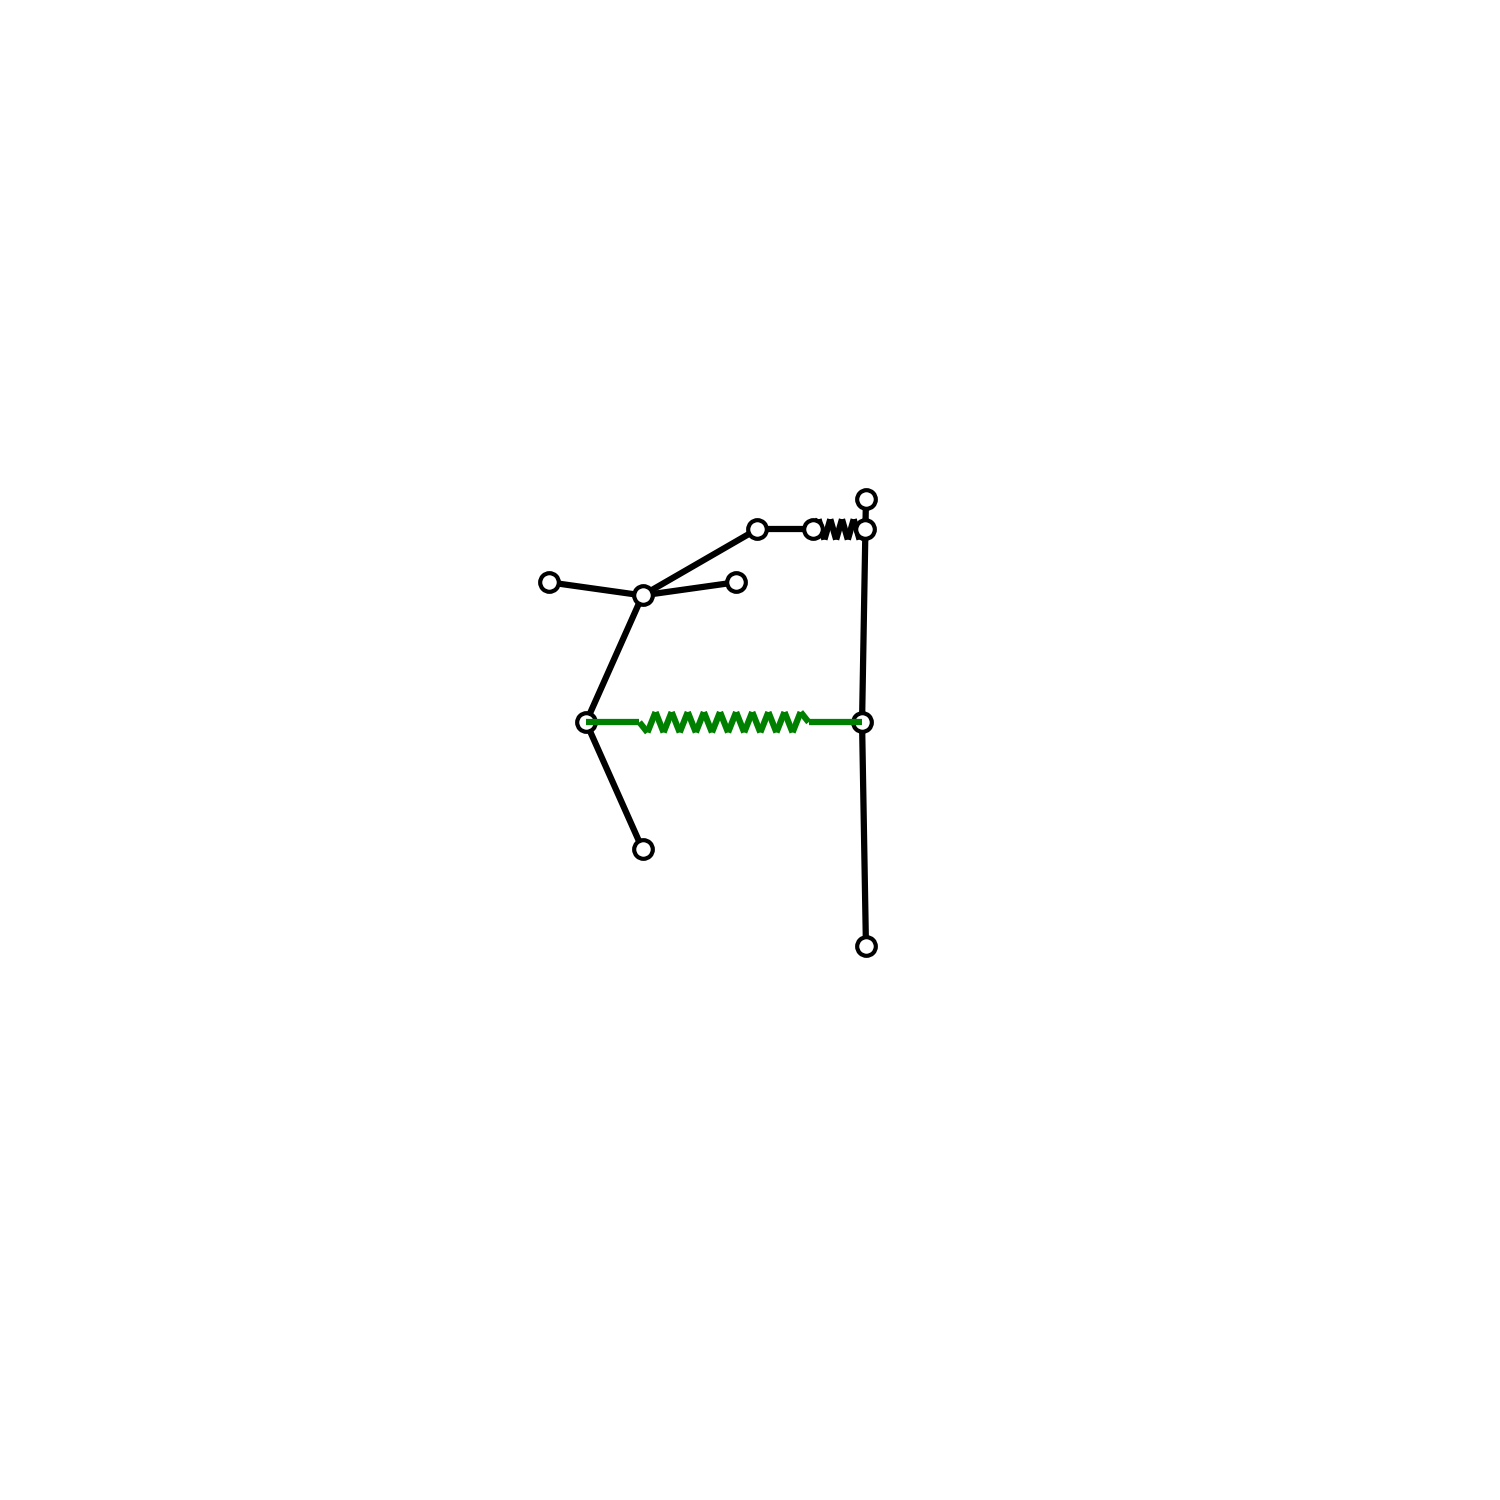

In [19]:
fig

In [20]:
from matplotlib.animation import FuncAnimation

anim = FuncAnimation(fig, update, frames=200)


Todo:
-set coupling stiffness to zero, sweep alpha, plot residuals [Done]
-set correct coupling stiffnesses 
- extract other values from prbm (i.e. intermediate angles)
-implement optimisation algorithm [Done?]
-implement constraints handling: spring or optimisation constraints?
-visualise system



In [21]:
anim.save('tessellation.mp4', writer='ffmpeg', fps=30)